In [1]:
import pandas as pd
import json
from glob import glob
from upsetplot import from_contents,plot,UpSet,from_memberships
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import combinations
import numpy as np

# Set the PDF font type to 42
plt.rcParams['pdf.fonttype'] = 42

# Annotations

## NER

Gather all of the annotations and prediction numbers relating to the NER task.

In [2]:
labels = glob("../label/*.json")
labels.sort()
# Read the json file
with open(labels[-1]) as f:
    data = json.load(f)
    print(f)

<_io.TextIOWrapper name='../label/project-5-at-2024-09-08-17-48-b8d4d57e.json' mode='r' encoding='UTF-8'>


In [3]:
entity_sentences = {}
relation_counts = {}

for sentence in data:
    sentenceid = sentence["id"]
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            entity = annotation["value"]["labels"][0]
            if entity not in ["VIRUS", "ASSEMBLY", "GENUS", "GENE","PROTEIN"]:
                if entity not in entity_sentences:
                    entity_sentences[entity] = set()
                entity_sentences[entity].add(sentenceid)
        elif annotation["type"] == "relation":
            if sentenceid not in relation_counts:
                relation_counts[sentenceid] = 0
            relation_counts[sentenceid] += 1


In [4]:
df_relation_counts = pd.DataFrame.from_dict(relation_counts, orient='index', columns=['Count'])
df_relation_counts.index.name = 'id'
df_relation_counts.reset_index(inplace=True)


In [5]:
df_sentences = from_contents(entity_sentences)

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


In [6]:
df_onlystrain = df_sentences.reset_index()
df_onlystrain.loc[df_onlystrain['STRAIN'] == False, :] = False
df_onlystrain.set_index(df_onlystrain.columns[:-1].tolist(), inplace=True)
df_onlystrain.loc[:,"id"] = df_sentences.id.to_list()

/scratch/slurm_tmpdir/job_24406350/ipykernel_309070/3042944905.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_onlystrain.loc[df_onlystrain['STRAIN'] == False, :] = False


In [7]:
df_strain_rel = df_onlystrain.merge(df_relation_counts, on="id", how="left", validate="one_to_one").fillna(0)

/scratch/slurm_tmpdir/job_24406350/ipykernel_309070/978306463.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_strain_rel = df_onlystrain.merge(df_relation_counts, on="id", how="left", validate="one_to_one").fillna(0)


In [8]:
df_onlystrain.loc[:,"count"] = df_strain_rel.Count.astype(int).to_list()

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

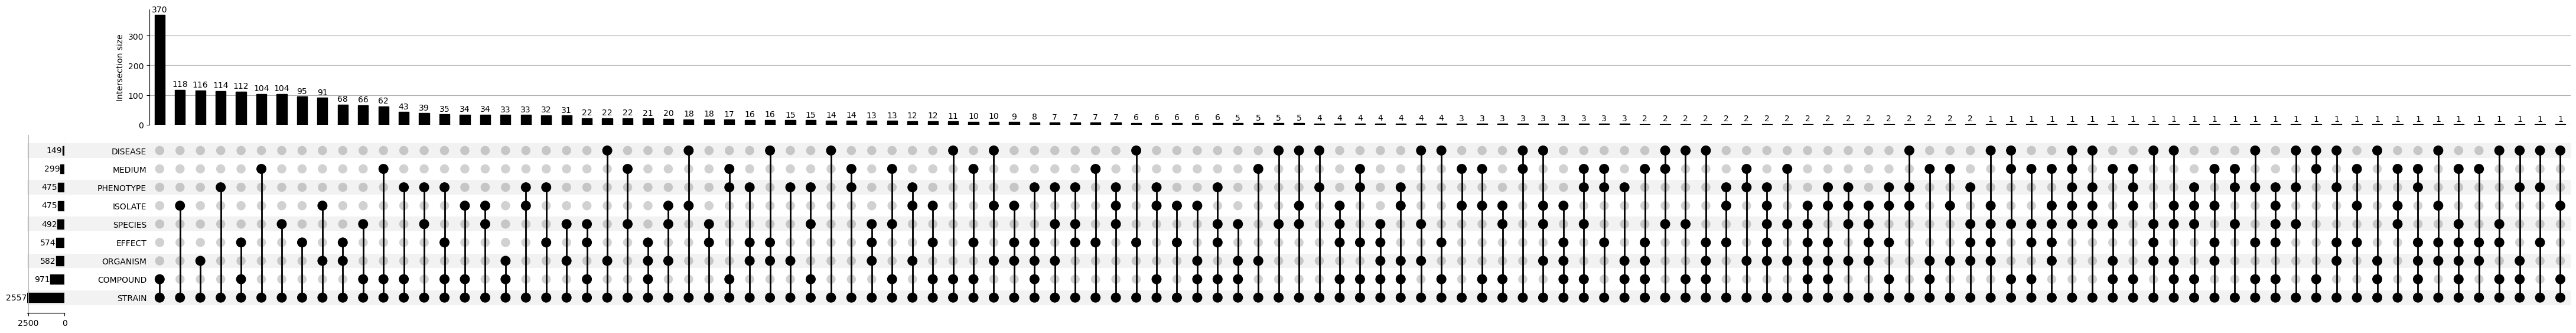

In [9]:
plot(df_onlystrain, min_degree=2,sort_by="cardinality",show_counts="%d")
plt.savefig("figures/predictions/ner_label.pdf")

Add rels on top

In [10]:
upset = UpSet(df_onlystrain,
              intersection_plot_elements=0)

In [11]:
df_onlystrain

id  \
STRAIN SPECIES EFFECT COMPOUND ISOLATE PHENOTYPE DISEASE ORGANISM MEDIUM          
True   False   False  False    False   False     False   False    False   11136   
                                                                  False   11137   
       True    True   False    False   False     False   False    False   11138   
               False  True     False   False     False   False    False   11139   
                      False    False   False     False   False    False   11140   
...                                                                         ...   
False  False   False  False    False   False     False   False    False   14325   
                                                                  False   14415   
                                                                  False   14811   
                                                                  False   11317   
                                                                  False   14018   

                                                                          count  
STRAIN SPECIES EFFECT COMPOUND ISOLATE PHENOTYPE DISEASE ORGANISM MEDIUM         
True   False   False  False    False   False     False   False    False       0  
                                                                  False       0  
       True    True   False    False   False     False   False    False       0  
               False  True     False   False     False   False    False       0  
                      False    False   False     False   False    False       0  
...                                                                         ...  
False  False   False  False    False   False     False   False    False       1  
                                                                  False       0  
                                                                  False       0  
                                                                  False       0  
                                                                  False       0  

[3680 rows x 2 columns]

In [12]:
df_onlystrain.loc[:,"RE"] = df_onlystrain["count"].astype(bool)

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

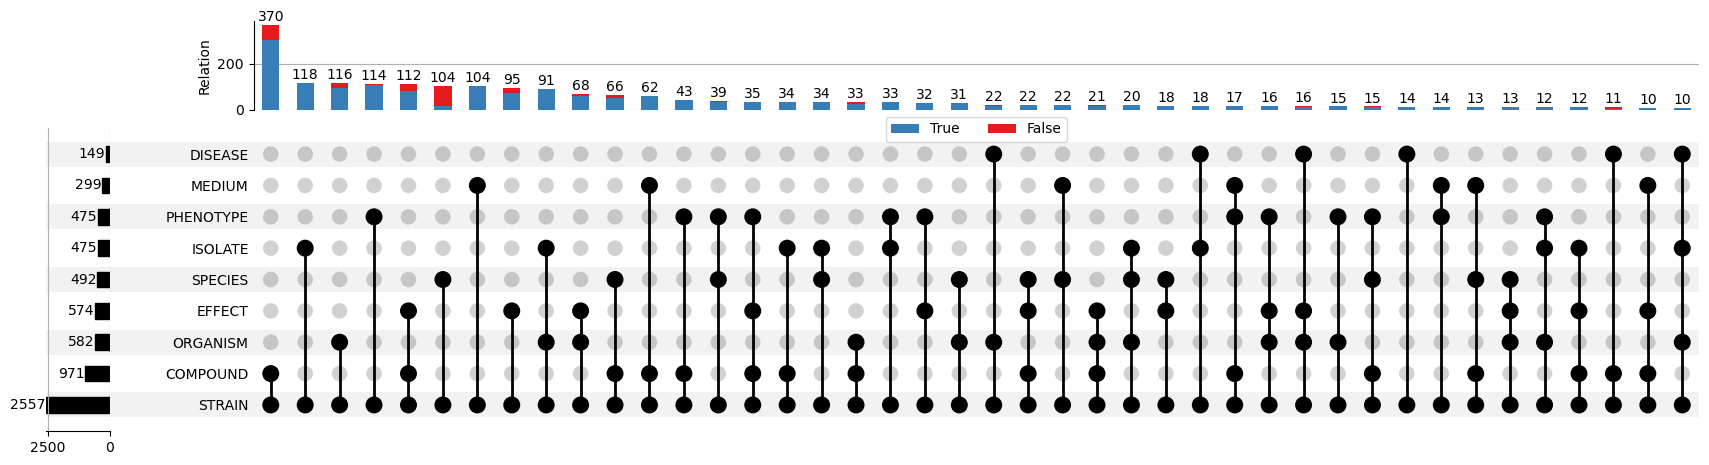

In [13]:
upset = UpSet(df_onlystrain,
			  intersection_plot_elements=0,show_counts=True,sort_by="cardinality", min_degree=2, min_subset_size=10)
upset.add_stacked_bars(by="RE", title="Relation", colors=cm.Set1)
upset.plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)
plt.savefig("figures/predictions/ner_rel_label.pdf")

## Pairwise REL

In [14]:
l = []
for sentence in data:
	annotations_sentence = {}
	relations_sentence = {}
	for annotation in sentence["annotations"][0]["result"]:
		if annotation["type"] == "labels":
			entity = annotation["value"]["labels"][0]
			entity_id = annotation["id"]
			if entity not in ["VIRUS", "ASSEMBLY", "GENUS","GENE","PROTEIN"]:
				annotations_sentence[entity_id] = entity
		elif annotation["type"] == "relation":
			relation_labels = annotation.get("labels", "")
			from_id = annotation["from_id"]
			to_id = annotation["to_id"]
			relations_sentence[(from_id, to_id)] = relation_labels
			relations_sentence[(to_id, from_id)] = relation_labels
	iterations = [comb for comb in combinations(annotations_sentence.keys(), 2)]
	iterations_label = [comb for comb in combinations(annotations_sentence.values(), 2)]
	relation_labels_list = [relations_sentence.get((from_id, to_id), "") for from_id, to_id in iterations]

	df_relations = pd.DataFrame({"from_id": [from_id for from_id, to_id in iterations],
								"to_id": [to_id for from_id, to_id in iterations],
								"relation": relation_labels_list,
								"label": iterations_label})
	l.append(df_relations)
pairwise = pd.concat(l)

In [15]:
pairwise[['l1', 'l2']] = pd.DataFrame(pairwise['label'].tolist(), index=pairwise.index)

In [16]:
filtered_pairwise = pairwise[(pairwise['l1'] == 'STRAIN') ^ (pairwise['l2'] == 'STRAIN')]


In [17]:
filtered_pairwise.loc[:,'relation'] = filtered_pairwise['relation'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '')


In [18]:
filtered_pairwise.loc[:,"id"] = filtered_pairwise["from_id"].astype(str) + "_" + filtered_pairwise["to_id"].astype(str)

/scratch/slurm_tmpdir/job_24406350/ipykernel_309070/1099094297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairwise.loc[:,"id"] = filtered_pairwise["from_id"].astype(str) + "_" + filtered_pairwise["to_id"].astype(str)


In [19]:
filtered_pairwise.loc[:,"labels"] = filtered_pairwise["l1"] + "_" + filtered_pairwise["l2"]

/scratch/slurm_tmpdir/job_24406350/ipykernel_309070/3345065246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairwise.loc[:,"labels"] = filtered_pairwise["l1"] + "_" + filtered_pairwise["l2"]


In [20]:
pairwise_from_member = from_memberships(filtered_pairwise.labels.str.split('_'), data=filtered_pairwise)

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


In [21]:
pairwise_from_member.loc[:,"relation_boolean"] = pairwise_from_member["relation"].astype(bool)

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

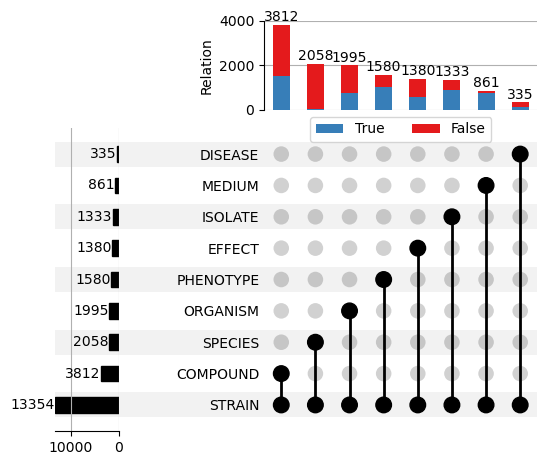

In [22]:
upset = UpSet(pairwise_from_member.replace("","None"),
			  intersection_plot_elements=0,show_counts=True)
upset.add_stacked_bars(by="relation_boolean", title="Relation", colors=cm.Set1)
upset.plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)  # Move the legend to the bottom center
plt.savefig("figures/predictions/pairwise_ner_rel_label.pdf")

# Predictions

In [23]:
data = "2009"

In [24]:
ner_preds = pd.read_parquet(f"../../preds{data}/NER_output/preds.parquet")

In [25]:
rel_preds = pd.read_parquet(f"../../preds{data}/REL_output/preds_strainselect_grouped.pqt")

In [26]:
merged = ner_preds.merge(rel_preds, on=["text","ner","word"], how="left")

In [27]:
small_merged = merged[["ner","rel"]]

In [28]:
small_merged.loc[:,"rel_bool"] = small_merged.rel.replace(np.nan,"").astype(bool)

/scratch/slurm_tmpdir/job_24406350/ipykernel_309070/2224905871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_merged.loc[:,"rel_bool"] = small_merged.rel.replace(np.nan,"").astype(bool)


In [29]:
small_merged.loc[:,"rel_strain"] = "STRAIN"

/scratch/slurm_tmpdir/job_24406350/ipykernel_309070/3634124913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_merged.loc[:,"rel_strain"] = "STRAIN"


In [30]:
small_merged = small_merged[small_merged.ner != "GENUS"]

In [31]:
small_merged.loc[:,"labels"] = small_merged["ner"] + "_" + small_merged["rel_strain"]

In [32]:
small_merged_membership = from_memberships(small_merged.labels.str.split('_'), data=small_merged)

/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/pfs/data5/home/tu/tu_tu/tu_kmpaj01/miniforge3/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

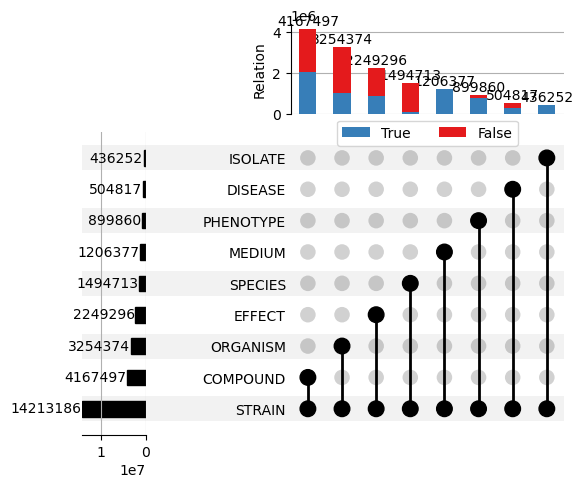

In [33]:
upset = UpSet(small_merged_membership,
			  intersection_plot_elements=0,show_counts=True)
upset.add_stacked_bars(by="rel_bool", title="Relation", colors=cm.Set1)
upset.plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)  # Move the legend to the bottom center
plt.savefig("figures/predictions/pairwise_ner_rel_predictions.pdf")